
# Comparison between experimental data and model results

## Model Description
From the EEI model, we notice that for most parameters are constants, only $\alpha$ and $\xi$ are the parameters that we can adjust to fit the experimental data. Here we try to use three ways to find the optimal values of $\alpha$ and/or $\xi$. 



In [ ]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# Constants
k_B = 1.38e-23      # Boltzmann constant (J/K)
epsilon_r = 78.5    # Relative permittivity of water
epsilon_0 = 8.85e-12# Permittivity of vacuum (F/m)
phi_c = 0.646       # Critical volume fraction
e = 1.602e-19       # Elementary charge (C)
N_A = 6.0221e23     # Avogadro's number (mol^-1)

# Experimental Data

In [ ]:
samples = [ # mayo1, mayo2, mayo3, mayo4, mayo5
           ]

In [4]:
def compute_lambda_D(T, I):
    numerator = epsilon_r * epsilon_0 * k_B * T
    denominator = 2 * e**2 * N_A * I * 1e3  # 1e3 factor for converting I to m^3 units
    return np.sqrt(numerator / denominator)

def F_int(phi_d, a, xi, sigma):
    return 4 * np.pi * xi * sigma * (a**2) * (phi_d**2)

def F_ent(phi, phi_d, gamma, T, alpha):
    # Avoid log of non-positive number
    term = phi_c + phi_d - phi - alpha * gamma**2
    if term <= 0:
        return np.inf
    return -3 * k_B * T * np.log(term)

def F_elec(phi_d, phi, gamma, T, a, psi_0, lambda_D, alpha):
    term = phi_c + phi_d - alpha * gamma**2
    if term <= 0:
        return np.inf
    h = 2 * (phi_c)**(1/3) * a * (phi**(-1/3) - term**(-1/3))
    if h <= 0:
        return np.inf
    numerator = 2 * np.pi * a**2 * epsilon_r * epsilon_0 * psi_0**2 * np.exp(-h / lambda_D)
    return numerator / h

def F_tot(phi_d, phi, gamma, T, a, xi, sigma, psi_0, lambda_D, alpha):
    return (F_int(phi_d, a, xi, sigma)
            + F_ent(phi, phi_d, gamma, T, alpha)
            + F_elec(phi_d, phi, gamma, T, a, psi_0, lambda_D, alpha))

def find_min_phi_d(phi, gamma, T, a, xi, sigma, psi_0, lambda_D, alpha):
    boundary_condition = phi_c - phi - alpha * gamma**2
    if boundary_condition > 0:
        lower_bound = 0.0
    else:
        lower_bound = phi + alpha * gamma**2 - phi_c
    # Ensure upper_bound is greater than lower_bound
    upper_bound = max(lower_bound + 1e-6, 1.0)
    
    def objective(phi_d):
        return F_tot(phi_d, phi, gamma, T, a, xi, sigma, psi_0, lambda_D, alpha)
    
    result = minimize_scalar(objective, bounds=(lower_bound, upper_bound), method='bounded')
    if result.success:
        return result.x
    else:
        return np.nan

def compute_G_p_tot(xi, alpha, T, phi, a, I, sigma, psi_0):
    # Droplet volume
    V_drop = (4/3) * np.pi * a**3
    lambda_D = compute_lambda_D(T, I)

    # Generate gamma range and compute minimized F_tot for each
    gamma_vals = np.linspace(0, 0.01, num=50)
    F_tot_star_list = []
    for gamma in gamma_vals:
        phi_d_star = find_min_phi_d(phi, gamma, T, a, xi, sigma, psi_0, lambda_D, alpha)
        if np.isnan(phi_d_star) or np.isinf(phi_d_star):
            F_tot_star_list.append(np.nan)
        else:
            val = F_tot(phi_d_star, phi, gamma, T, a, xi, sigma, psi_0, lambda_D, alpha)
            F_tot_star_list.append(val)

    # Convert to numpy arrays
    gamma_array = np.array(gamma_vals)
    F_tot_star_array = np.array(F_tot_star_list)

    # Remove NaNs before spline interpolation
    valid_mask = ~np.isnan(F_tot_star_array)
    if np.sum(valid_mask) < 4:  # CubicSpline requires at least 4 points
        return np.nan

    gamma_valid = gamma_array[valid_mask]
    F_tot_valid = F_tot_star_array[valid_mask]

    spline = CubicSpline(gamma_valid, F_tot_valid)
    second_derivative = spline.derivative(2)(0.0)  # Evaluate second derivative at gamma=0
    
    return (phi / V_drop) * second_derivative



###############################################################################
# 1) Fit both xi and alpha for each sample

print("=== 1) Fit xi and alpha for each sample ===")
for i, s in enumerate(samples, start=1):
    exp_val = s["exp_Gp"]
    
    # Objective function: single data point => (Gp - expVal)^2
    def objective(x):
        xi_trial, alpha_trial = x
        gp_calc = compute_G_p_tot(xi_trial, alpha_trial, 
                                  s["T"], s["phi"], s["a"], s["I"], 
                                  s["sigma"], s["psi_0"])
        # If gp_calc is NaN or inf, penalize heavily
        if np.isnan(gp_calc) or np.isinf(gp_calc):
            return 1e20
        return (gp_calc - exp_val)**2

    # Bounds: xi in (0.1, 1.5), alpha in (0.5, 1.0)
    bnds = [(0.1, 1.5), (0.5, 2.1)]
    result = minimize(objective, x0=[0.5, 0.75], bounds=bnds, method='SLSQP')
    
    if result.success:
        xi_opt, alpha_opt = result.x
        gp_opt = compute_G_p_tot(xi_opt, alpha_opt, s["T"], s["phi"], s["a"], s["I"], s["sigma"], s["psi_0"])
        error = abs(gp_opt - exp_val)
        print(f"Sample {i}: xi={xi_opt:.4f}, alpha={alpha_opt:.4f}, "
              f"Gp={gp_opt:.4f}, Exp={exp_val:.4f}, Error={error:.4f}")
    else:
        print(f"Sample {i}: Optimization failed.")

###############################################################################
# 2) Fix xi, fit alpha for each sample
xi_fixed = 0.5
print(f"\n=== 2) Fix xi={xi_fixed}, fit alpha for each sample ===")


for i, s in enumerate(samples, start=1):
    exp_val = s["exp_Gp"]
    
    # Objective: alpha is the only variable
    def objective_scalar(alpha_trial):
        gp_calc = compute_G_p_tot(xi_fixed, alpha_trial, s["T"], s["phi"], s["a"], s["I"], s["sigma"], s["psi_0"])
        if np.isnan(gp_calc) or np.isinf(gp_calc):
            return 1e20
        return (gp_calc - exp_val)**2

    # alpha in (0.5, 1.0)
    result = minimize_scalar(objective_scalar, bounds=(0.1, 5), method='bounded')
    if result.success:
        alpha_opt = result.x
        gp_opt = compute_G_p_tot(xi_fixed, alpha_opt, s["T"], s["phi"], s["a"], s["I"], s["sigma"], s["psi_0"])
        error = abs(gp_opt - exp_val)
        print(f"Sample {i}: alpha={alpha_opt:.4f}, Gp={gp_opt:.4f}, "
              f"Exp={exp_val:.4f}, Error={error:.4f}")
    else:
        print(f"Sample {i}: Optimization failed.")

###############################################################################
# 3) Fix alpha, fit xi for each sample
alpha_fixed = 0.85
print(f"\n=== 3) Fix alpha={alpha_fixed}, fit xi for each sample ===")


for i, s in enumerate(samples, start=1):
    exp_val = s["exp_Gp"]
    
    # Objective: xi is the only variable
    def objective_scalar(xi_trial):
        gp_calc = compute_G_p_tot(xi_trial, alpha_fixed, s["T"], s["phi"], s["a"], s["I"], s["sigma"], s["psi_0"])
        if np.isnan(gp_calc) or np.isinf(gp_calc):
            return 1e20
        return (gp_calc - exp_val)**2

    # xi in (0.1, 1.5)
    result = minimize_scalar(objective_scalar, bounds=(0.1, 1.5), method='bounded')
    if result.success:
        xi_opt = result.x
        gp_opt = compute_G_p_tot(xi_opt, alpha_fixed, s["T"], s["phi"], s["a"], s["I"], s["sigma"], s["psi_0"])
        error = abs(gp_opt - exp_val)
        print(f"Sample {i}: xi={xi_opt:.4f}, Gp={gp_opt:.4f}, "
              f"Exp={exp_val:.4f}, Error={error:.4f}")
    else:
        print(f"Sample {i}: Optimization failed.")


=== 1) Fit xi and alpha for each sample ===
Sample 1: xi=0.5000, alpha=0.7500, Gp=969.4034, Exp=750.0000, Error=219.4034
Sample 2: xi=0.4065, alpha=0.7216, Gp=241.0366, Exp=241.0000, Error=0.0366
Sample 3: xi=0.5000, alpha=0.7500, Gp=702.8918, Exp=1000.0000, Error=297.1082
Sample 4: xi=0.5000, alpha=0.7500, Gp=131.5053, Exp=188.0000, Error=56.4947
Sample 5: xi=0.8718, alpha=1.2406, Gp=55.9636, Exp=56.0000, Error=0.0364

=== 2) Fix xi=0.5, fit alpha for each sample ===
Sample 1: alpha=0.5803, Gp=749.9981, Exp=750.0000, Error=0.0019
Sample 2: alpha=0.5885, Gp=241.0003, Exp=241.0000, Error=0.0003
Sample 3: alpha=1.0670, Gp=999.9997, Exp=1000.0000, Error=0.0003
Sample 4: alpha=1.0722, Gp=187.9999, Exp=188.0000, Error=0.0001
Sample 5: alpha=2.0959, Gp=56.0000, Exp=56.0000, Error=0.0000

=== 3) Fix alpha=0.85, fit xi for each sample ===
Sample 1: xi=0.3396, Gp=750.0000, Exp=750.0000, Error=0.0000
Sample 2: xi=0.3442, Gp=240.9999, Exp=241.0000, Error=0.0001
Sample 3: xi=0.6277, Gp=1000.0011, 

# Global Fit

In [5]:
def objective_global(x):

    xi_val, alpha_val = x
    total_error = 0.0
    
    for s in samples:
        gp_calc = compute_G_p_tot(
            xi_val, alpha_val,
            s["T"], s["phi"], s["a"], s["I"],
            s["sigma"], s["psi_0"]
        )
        if np.isnan(gp_calc) or np.isinf(gp_calc):
            # If invalid, assign a large penalty
            total_error += 1e10
        else:
            diff = gp_calc - s["exp_Gp"]
            total_error += abs(diff)
    
    return total_error

# Set bounds: xi in (0.1, 1.5) and alpha in (0.5, 1.0)
bounds = [(0.1, 1.5), (0.5, 1.0)]
# Initial guess
x0 = [0.5, 0.85]

res = minimize(objective_global, x0, bounds=bounds, method='SLSQP')

if res.success:
    xi_opt, alpha_opt = res.x
    print(f"Global fit successful!")
    print(f"Optimal xi = {xi_opt:.4f}")
    print(f"Optimal alpha = {alpha_opt:.4f}")
    
    # Compute final Gp for each sample under these optimal parameters
    total_error_final = 0.0
    for i, s in enumerate(samples, start=1):
        gp_pred = compute_G_p_tot(
            xi_opt, alpha_opt,
            s["T"], s["phi"], s["a"], s["I"],
            s["sigma"], s["psi_0"]
        )
        error_i = gp_pred - s["exp_Gp"]
        total_error_final += abs(error_i)
        print(f"Sample {i}: Gp_pred = {gp_pred:.2f}, Gp_exp = {s['exp_Gp']:.2f}, Error = {error_i:.2f}")
    print(f"Sum of squared errors = {total_error_final:.2f}")
else:
    print("Global fit failed.")

Global fit successful!
Optimal xi = 0.3885
Optimal alpha = 0.7523
Sample 1: Gp_pred = 758.02, Gp_exp = 750.00, Error = 8.02
Sample 2: Gp_pred = 240.30, Gp_exp = 241.00, Error = -0.70
Sample 3: Gp_pred = 547.84, Gp_exp = 1000.00, Error = -452.16
Sample 4: Gp_pred = 102.63, Gp_exp = 188.00, Error = -85.37
Sample 5: Gp_pred = 15.85, Gp_exp = 56.00, Error = -40.15
Sum of squared errors = 586.40


# Fitting for each sample

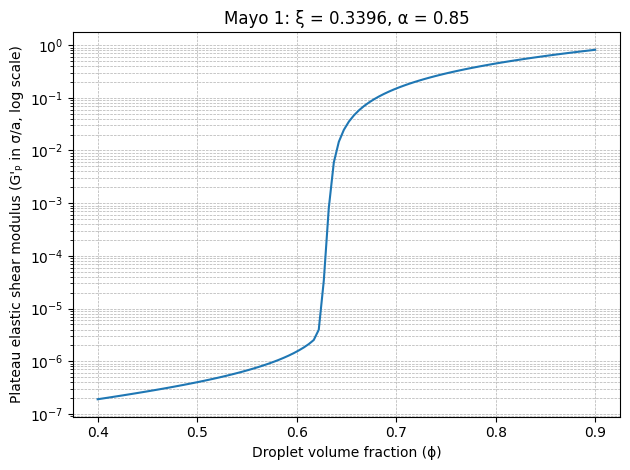

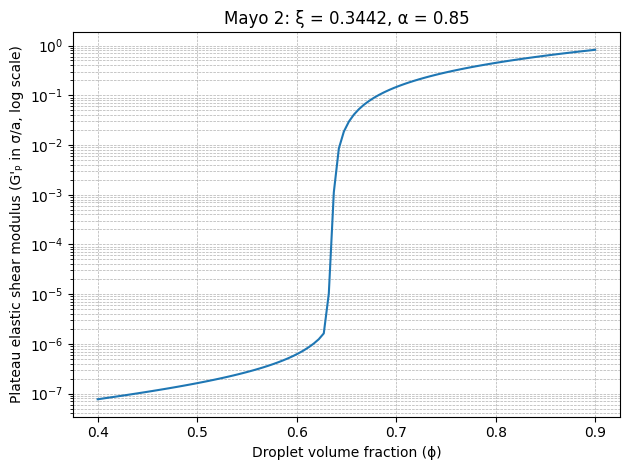

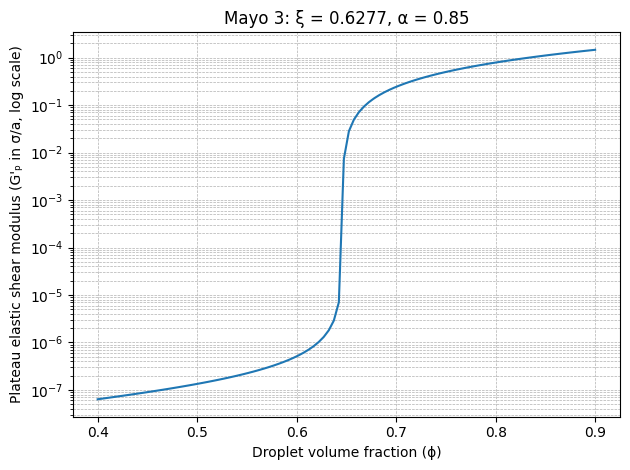

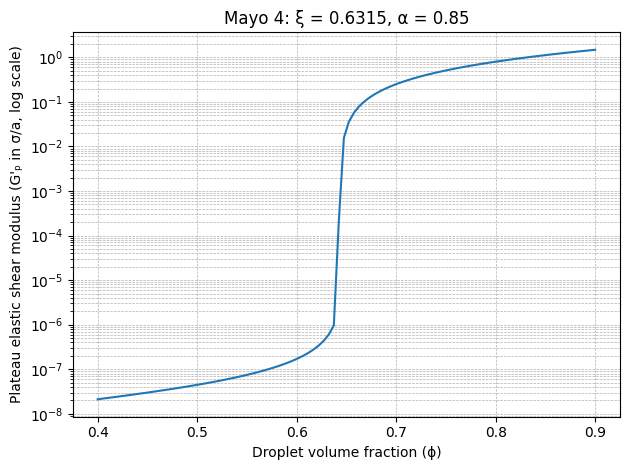

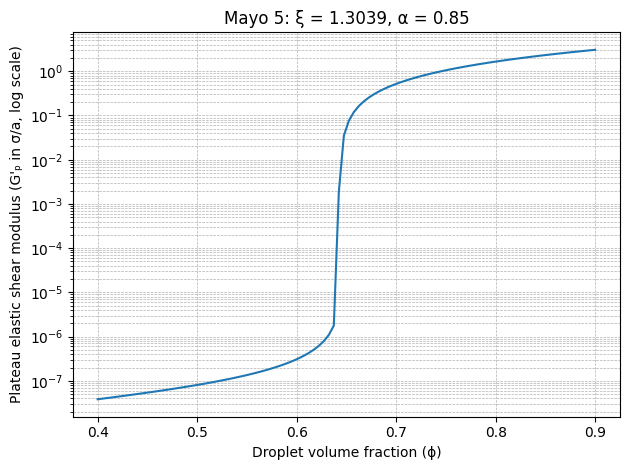

In [6]:
alpha_fixed = 0.85

xi_fitted = [0.3396, 0.3442, 0.6277, 0.6315, 1.3039]

for s, xi_val in zip(samples, xi_fitted):
    s["xi_fit"] = xi_val         
phi_scan = np.linspace(0.4, 0.9, 100)

for idx, s in enumerate(samples, start=1):
    xi_val = s["xi_fit"]
    Gp_vals = [
        compute_G_p_tot(
            xi_val, alpha_fixed, s["T"], phi_val,
            s["a"], s["I"], s["sigma"], s["psi_0"]
        ) / s["sigma"] * s["a"]
        for phi_val in phi_scan
    ]

    fig, ax = plt.subplots()
    ax.plot(phi_scan, Gp_vals)

    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    ax.set_xlabel("Droplet volume fraction (ϕ)")
    ax.set_ylabel("Plateau elastic shear modulus (G'ₚ in σ/a, log scale)")
    ax.set_title(f"Mayo {idx}: ξ = {xi_val:.4f}, α = {alpha_fixed}")

    fig.tight_layout()
    plt.show()

# All samples

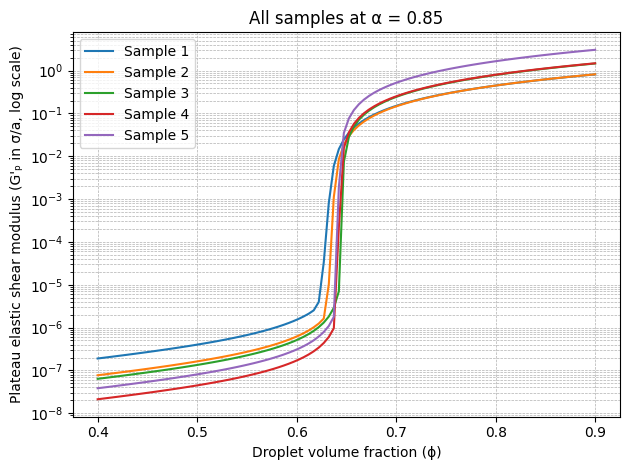

In [19]:
fig, ax = plt.subplots()

for idx, s in enumerate(samples, start=1):
    xi_val = s["xi_fit"]
    Gp_vals = [
        compute_G_p_tot(
            xi_val, alpha_fixed, s["T"], phi_val,
            s["a"], s["I"], s["sigma"], s["psi_0"]
        ) / s["sigma"] * s["a"]
        for phi_val in phi_scan
    ]
    ax.plot(phi_scan, Gp_vals, label=f"Sample {idx}")


ax.set_yscale("log")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_xlabel("Droplet volume fraction (ϕ)")
ax.set_ylabel("Plateau elastic shear modulus (G'ₚ in σ/a, log scale)")
ax.set_title(f"All samples at α = {alpha_fixed}")
ax.legend()
fig.tight_layout()
plt.show()